## LadyBug - Prediction of a 2D trajectory via RNN

Artificial dataset generation and prediction attempt via a recurrent network


Objectives :
Understanding the use of a recurrent neural network for time series

1. Import and Initialization

In [55]:
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import math, random
from math import sin,cos,pi
import matplotlib.pyplot as plt

import pandas as pd
import os,time,sys

2. Parameters

In [2]:
# ---- About dataset
#
max_t        = 1000
delta_t      = 0.02
features_len = 2


sequence_len = 20
predict_len  = 5

# ---- About training
#
scale         = .2       # Percentage of dataset to be used (1=all)
train_prop    = .8       # Percentage for train (the rest being for the test)
batch_size    = 32
epochs        = 5
fit_verbosity = 1        # 0 = silent, 1 = progress bar, 2 = one line per epoch

3. Generation of a fun dataset

    3.1. Virtual trajectory of our ladybug

In [3]:
def ladybug_init(s=122):
    if s>0 : random.seed(s)
    ladybug_init.params_x = [ random.gauss(0.,1.) for u in range(8)]
    ladybug_init.params_y = [ random.gauss(0.,1.) for u in range(8)]
    
def ladybug_move(t):
    k=0.5
    [ax1, ax2, ax3, ax4, kx1, kx2, kx3, kx4] = ladybug_init.params_x
    [ay1, ay2, ay3, ay4, ky1, ky2, ky3, ky4] = ladybug_init.params_y
    
    x = ax1*sin(t*(kx1+20)) + ax2*cos(t*(kx2+10)) + ax3*sin(t*(kx3+5)) + ax4*cos(t*(kx4+5))
    y = ay1*cos(t*(ky1+20)) + ay2*sin(t*(ky2+10)) + ay3*cos(t*(ky3+5)) + ay4*sin(t*(ky4+5)) 

    return x,y

    3.2. Get some positions, and build a rescaled and normalized dataset

In [4]:
# ---- Get positions
#
ladybug_init(s=16)
x,y = 0,0
positions=[]
for t in np.arange(0., max_t, delta_t):
    x,y = ladybug_move(t)
    positions.append([x,y])

# ---- Build rescaled dataset
#
n = int( len(positions)*scale )
dataset = np.array(positions[:n])

k = int(len(dataset)*train_prop)
x_train = dataset[:k]
x_test  = dataset[k:]

# ---- Normalize
#
mean = x_train.mean()
std  = x_train.std()
x_train = (x_train - mean) / std
x_test  = (x_test  - mean) / std

print("Dataset generated.")
print("Train shape is : ", x_train.shape)
print("Test  shape is : ", x_test.shape)

Dataset generated.
Train shape is :  (8000, 2)
Test  shape is :  (2000, 2)


3.3. First look

An extract from the data we have: the virtual trajectory of our ladybugAnd what we want to predict (in red), from a segment (in blue)

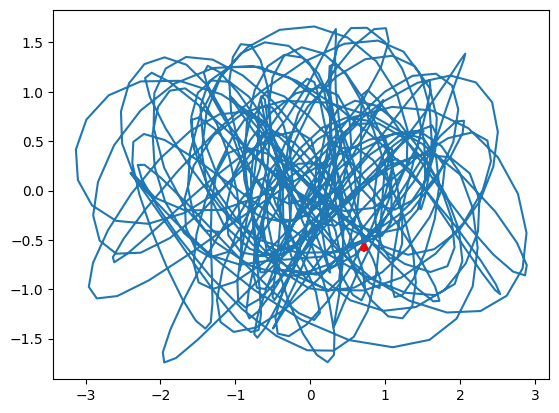

In [43]:
fig, ax = plt.subplots()
Xs = x_train[:1000, 0].reshape(1000)
Ys = x_train[:1000, 1].reshape(1000)

ax.plot(Xs, Ys)
ax.plot(Xs[-1], Ys[-1], ls="",c="red",  marker=r'$\clubsuit$',
           label="Luck")
plt.show()

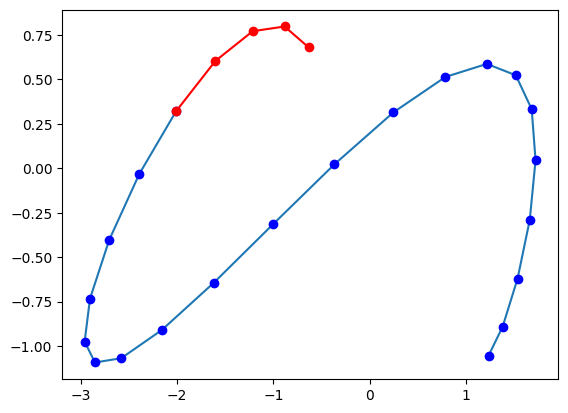

In [52]:
k1,k2 = sequence_len, predict_len
i = random.randint(0,len(x_test)-k1-k2)
j = i+k1

fig, ax = plt.subplots()
Xpas = x_train[i:j+1, 0].reshape(k1+1)
Ypas = x_train[i:j+1, 1].reshape(k1+1)

Xpred = x_train[j:j+k2, 0].reshape(k2)
Ypred = x_train[j:j+k2, 1].reshape(k2)

ax.plot(Xpas, Ypas)
ax.plot(Xpred, Ypred, c="red")
ax.plot(Xpas, Ypas, ls="",c="blue",  marker="o",
           label="points")
ax.plot(Xpred, Ypred, ls="",c="red",  marker="o",
           label="points")
plt.show()

3.4. Prepare some nice data generator

In [53]:
train_generator = TimeseriesGenerator(x_train, x_train, length=sequence_len,  batch_size=batch_size)
test_generator  = TimeseriesGenerator(x_test,  x_test,  length=sequence_len,  batch_size=batch_size)



x,y=train_generator[0]
print(f'Number of batch trains available : ', len(train_generator))
print('batch x shape : ',x.shape)
print('batch y shape : ',y.shape)

Number of batch trains available :  250
batch x shape :  (32, 20, 2)
batch y shape :  (32, 2)


In [54]:
rnn_model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(sequence_len, features_len)),
    keras.layers.GRU(200, return_sequences=False, activation='relu'),
    keras.layers.Dense(features_len)
])

rnn_model.summary()

Metal device set to: WARNING:tensorflow:Layer gru will not use cuDNN kernels since it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.


2023-02-10 02:30:51.077711: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-10 02:30:51.079622: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 200)               122400    
                                                                 
 dense (Dense)               (None, 2)                 402       
                                                                 
Total params: 122,802
Trainable params: 122,802
Non-trainable params: 0
_________________________________________________________________


In [56]:
os.makedirs(f'rnn/models',   mode=0o750, exist_ok=True)
save_path = f'rnn/models/best_model.h5'

bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_path, verbose=0, save_best_only=True)


# Compiler le modèle
rnn_model.compile(
    optimizer='rmsprop', 
              loss='mse', 
              metrics   = ['mae'] ,
)




In [57]:
history=rnn_model.fit(train_generator, 
                  epochs  = epochs, 
                  verbose = fit_verbosity,
                  validation_data = test_generator,
                  callbacks = [bestmodel_callback])

Epoch 1/5


2023-02-10 02:35:51.624067: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-10 02:35:52.061500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - ETA: 0s - loss: 0.1042 - mae: 0.2226

2023-02-10 02:37:34.157878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


250/250 [==============================] - 105s 413ms/step - loss: 0.1042 - mae: 0.2226 - val_loss: 0.0078 - val_mae: 0.0714
Epoch 2/5
250/250 [==============================] - 104s 414ms/step - loss: 0.0104 - mae: 0.0790 - val_loss: 0.0023 - val_mae: 0.0385
Epoch 3/5
250/250 [==============================] - 104s 415ms/step - loss: 0.0052 - mae: 0.0563 - val_loss: 0.0024 - val_mae: 0.0388
Epoch 4/5
250/250 [==============================] - 104s 414ms/step - loss: 0.0037 - mae: 0.0461 - val_loss: 0.0015 - val_mae: 0.0311
Epoch 5/5
250/250 [==============================] - 109s 434ms/step - loss: 0.0028 - mae: 0.0403 - val_loss: 0.0031 - val_mae: 0.0445


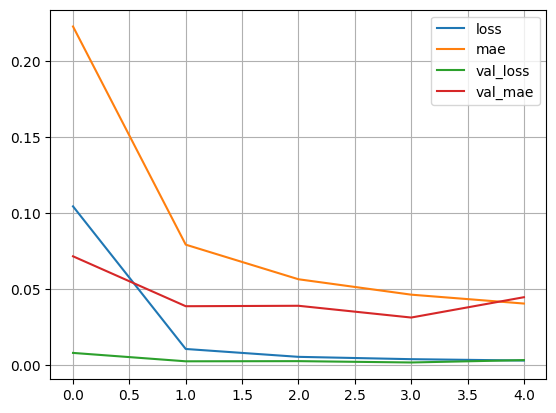

In [72]:
pd.DataFrame(history.history).plot()
plt.grid(True)

In [58]:
loaded_model = tf.keras.models.load_model(save_path)
print('Loaded.')

Loaded.


1/1 [==============================] - 0s 91ms/step
sequence shape      : (20, 2)
sequence true shape : (21, 2)
sequence pred shape : (1, 2)
[ 0.20834677 -1.115374  ]


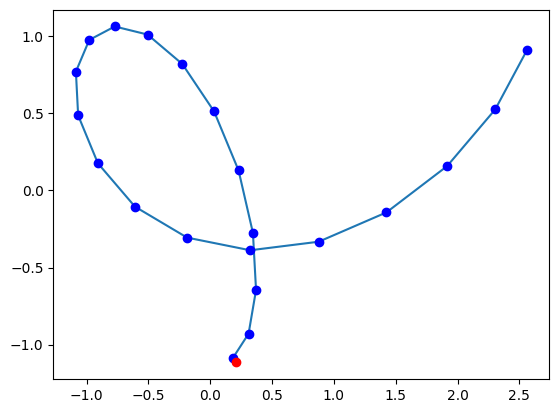

In [71]:
s=random.randint(0,len(x_test)-sequence_len)

sequence      = x_test[s:s+sequence_len]
sequence_true = x_test[s:s+sequence_len+1]

sequence_pred = loaded_model.predict( np.array([sequence]) )

print('sequence shape      :',sequence.shape)
print('sequence true shape :',sequence_true.shape)
print('sequence pred shape :',sequence_pred.shape)

fig, ax = plt.subplots()
sequence_pred= sequence_pred.reshape(features_len)
print(sequence_pred)
ax.plot(sequence_true[:, 0], sequence_true[:, 1])
ax.plot([sequence_true[sequence_len][0], sequence_pred[0]],
        [sequence_true[sequence_len][1], sequence_pred[1]], c="red")
ax.plot(sequence_true[:, 0], sequence_true[:, 1], ls="",c="blue",  marker="o",
           label="points")
ax.plot(sequence_pred[0], sequence_pred[1], ls="",c="red",  marker="o",
           label="points")
plt.show()